In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use('dark_background')

In [3]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
print(df.dtypes)

Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
                   ...   
3/5/23              int64
3/6/23              int64
3/7/23              int64
3/8/23              int64
3/9/23              int64
Length: 1147, dtype: object


In [4]:
country = "Greece"

In [5]:
df = df[df["Country/Region"] == country]
df = pd.DataFrame(df[df.columns[4:]].sum(),columns=["confirmed"])
df.index = pd.to_datetime(df.index,format='%m/%d/%y')

In [8]:
df

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2023-03-05,5548487
2023-03-06,5548487
2023-03-07,5548487
2023-03-08,5548487


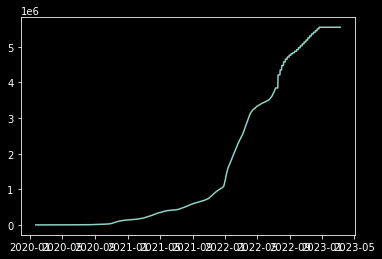

In [9]:
plt.plot(df['confirmed'])

In [10]:
from pmdarima.arima import ADFTest

In [11]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)
#Not stationary...

(0.7030649716788003, True)

In [12]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.9784121902860904  if above 0.05, data is not stationary


In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['confirmed'],  
                            model ='additive')

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid


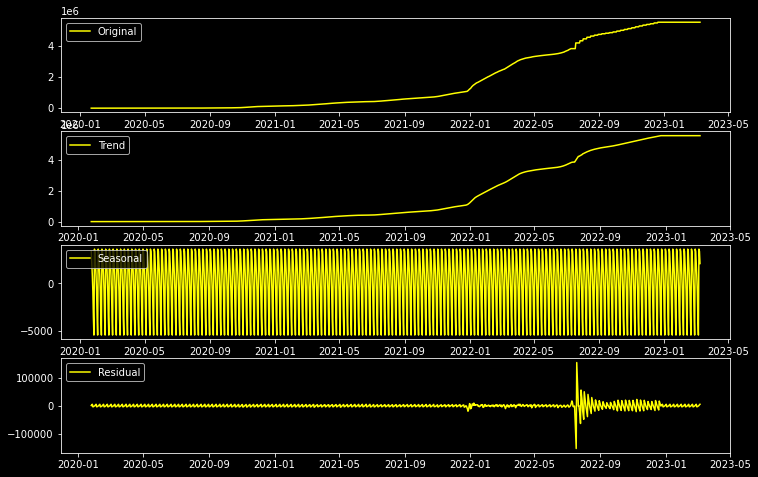

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

In [19]:
from pmdarima.arima import auto_arima

In [20]:
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components

In [21]:
arima_model = auto_arima(df['confirmed'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=100)        

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=25622.365, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=25649.829, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=25378.725, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25651.301, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=25297.007, Time=0.61 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=25248.895, Time=1.51 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=25231.302, Time=2.17 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=25220.266, Time=4.45 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=25160.909, Time=12.70 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=7.15 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=17.26 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=7.87 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=10.74 sec
 ARIMA(2,1,0)(5,1,1)[12]        

In [22]:
print(arima_model.summary() )

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1143
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 12)   Log Likelihood              -12572.454
Date:                              Sun, 04 Jun 2023   AIC                          25160.909
Time:                                      11:11:57   BIC                          25201.149
Sample:                                  01-22-2020   HQIC                         25176.112
                                       - 03-09-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0482      0.035      1.393      0.164      -0.020       0.116
ar.S.L12      -0.02

In [23]:
# Model: SARIMAX(1, 1, 0)x(5, 1, [1], 12)

In [43]:
#Split data into train and test
size = int(len(df) * 0.85)
X_train, X_test = df[0:size], df[size:len(df)]

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [45]:
model = SARIMAX(X_train['confirmed'],  
                order = (1, 1, 0),  
                seasonal_order =(5, 1, 1, 12)) 

C:\Users\jpolo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jpolo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [46]:
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            confirmed   No. Observations:                  971
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 12)   Log Likelihood              -10655.083
Date:                              Sun, 04 Jun 2023   AIC                          21326.165
Time:                                      11:16:31   BIC                          21365.084
Sample:                                  01-22-2020   HQIC                         21340.988
                                       - 09-18-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0622      0.031      2.002      0.045       0.001       0.123
ar.S.L12      -0.0763      0.148     -0.516      0.606      -0.366       0.213
ar.S.L24      -0.0685      0.136     -0.505      0.614      -0.335       0.198
ar.S.L36      -0.1002      0.129     -0.776      0.438      -0.353       0.153
ar.S.L48      -0.0504      0.121     -0.417      0.677      -0.288       0.187
ar.S.L60      -0.0847      0.129     -0.657      0.511      -0.337       0.168
ma.S.L12      -0.8526      0.144     -5.929      0.000      -1.134      -0.571
sigma2      4.199e+08   2.31e-09   1.82e+17      0.000     4.2e+08     4.2e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):           4740339.26
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):            1579.74   Skew:                            15.62
Prob(H) (two-sided):                  0.00   Kurtosis:                       346.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.21e+32. Standard errors may be unstable.
"""

In [47]:

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted confirmed') 

<AxesSubplot:>

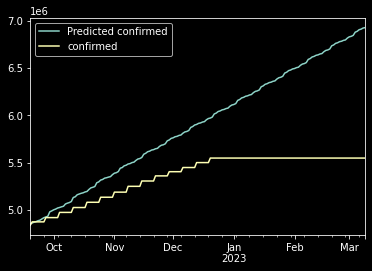

In [48]:
prediction.plot(legend = True) 
X_test['confirmed'].plot(legend = True)

In [50]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error

testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 673250.75 RMSE


In [51]:
from sklearn.metrics import r2_score
score = r2_score(X_test, prediction)
print("R2 score is: ", score)

R2 score is:  -7.350659797678965


In [52]:
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast')

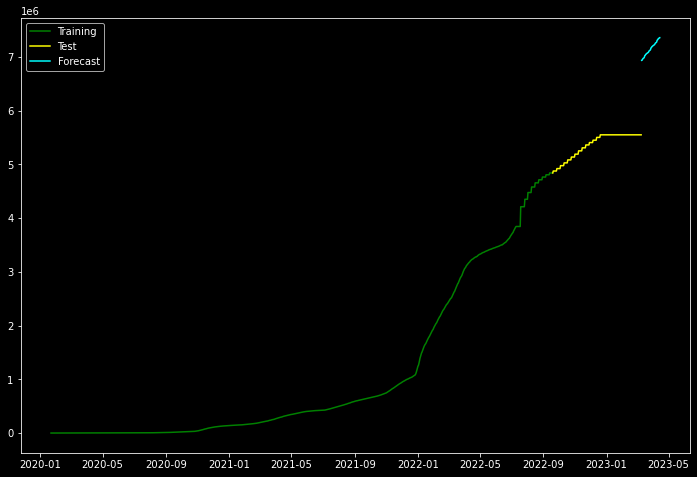

In [53]:
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()